# SVM Modeling

## Read Data from Dataset (raw & summary stats)

In [1]:
%matplotlib inline

import scipy.io as io
import numpy as np

data=io.loadmat('dataset_raw_sumMAT.mat' )
ds = data['ds']

print(len(ds[0,:]))
val=ds[0,0]
print(ds.dtype.names)
print(ds['mean'][0,1].dtype.names)





3720
('vpn', 'session', 'block', 'kat', 'img', 'trailID', 'condition', 'xr', 'xl', 'yr', 'yl', 'dur', 'pupil', 'blink', 'numberOfBlink', 'numberOfFix', 'rating', 'mean', 'std', 'nCat', 'nImg', 'nVpn')
('xr', 'yr', 'xl', 'yl', 'dur', 'pupil')


## Split dataset 
into a feature set X and a target set Y

In [2]:
dataset= ds[np.where(ds['condition'] == 'perception')]


# X -> features, y -> label
y =np.zeros((dataset.shape[0]))
X =np.zeros((dataset.shape[0],6))

for i in range(0,len(X[:,0]-1)):
    tmp=dataset['mean'][ i]
    X[i,0]=tmp['xr']
    X[i, 1] = tmp['xl']
    X[i, 2] = tmp['dur']
    X[i, 3] = tmp['pupil']
    X[i, 4] = dataset['numberOfFix'][i][0][0].astype('int')
    X[i, 5] = dataset['numberOfBlink'][i][0][0].astype('int')
    y[i] = ds['nCat'][0,i][0,0].astype(int)
    
    


## Clean nan samples

In [3]:
    
excld = np.logical_not(np.isnan(X))
print(excld)

print(X.shape)
print(y.shape)
print(X[excld[:,0]])
print(np.argwhere(excld))

X = X[excld[:,0]]
y = y[excld[:,0]]
print(X.shape)
print(y.shape)
print(y.astype('int'))

[[ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 ...
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]]
(1860, 6)
(1860,)
[[ 594.84807692  498.92307692  242.07692308 1050.51923077   52.
     7.        ]
 [ 706.68103448  502.95517241  216.79310345  964.87931034   58.
     5.        ]
 [ 625.70833333  536.41041667  266.41666667 1118.1875       48.
     6.        ]
 ...
 [ 743.7625      730.2625      373.5625      577.8125       32.
     9.        ]
 [ 665.58974359  522.85641026  316.          565.51282051   39.
     6.        ]
 [ 756.21777778  645.71333333  235.28888889  772.4          45.
    13.        ]]
[[   0    0]
 [   0    1]
 [   0    2]
 ...
 [1859    3]
 [1859    4]
 [1859    5]]
(1860, 6)
(1860,)
[1 1 1 ... 3 3 3]


## perform SVM
by splittin sets into test and training set and do linear SVM

In [4]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
 
# training a linear SVM classifier
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)
 
# model accuracy for X_test
accuracy = svm_model_linear.score(X_test, y_test)

print(accuracy)
# creating a confusion matrix

cm = confusion_matrix(y_test, svm_predictions)
print(cm)




0.6860215053763441
[[ 88  46  20]
 [ 42  97  18]
 [ 19   1 134]]


In [5]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

y = label_binarize(y, classes=[1, 2,3])
n_classes = y.shape[1]
print(n_classes)
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    


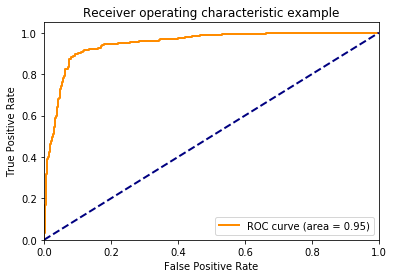

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

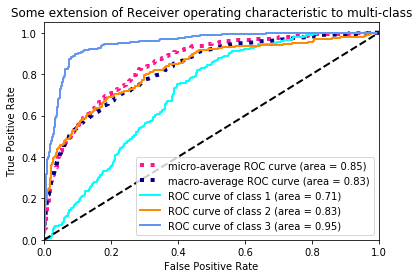

In [10]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()